In [1]:
# Índice de risco da COVID-19
# Carlo Ralph De Musis
# Junho/2020

In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3]

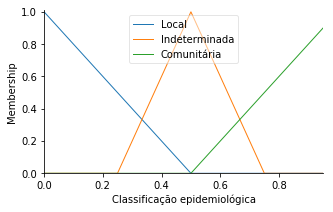

In [4]:
# Variável antecedente: classificação epidemiológica.
ce = ctrl.Antecedent(np.arange(0, 1, 0.05), 'Classificação epidemiológica')

ce['Local'] = fuzz.trimf(ce.universe, [0, 0, 0.5])
ce['Indeterminada'] = fuzz.trimf(ce.universe, [0.25, 0.5, 0.75])
ce['Comunitária']  = fuzz.trimf(ce.universe, [0.5, 1, 1])

ce.view()

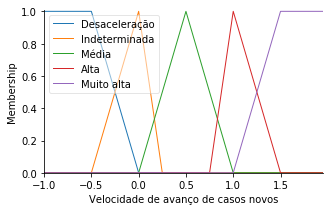

In [5]:
# Variável antecedente: velocidade de avanço de casos novos.
vacn = ctrl.Antecedent(np.arange(-1, 2, 0.05), 'Velocidade de avanço de casos novos')

vacn['Desaceleração'] = fuzz.trapmf(vacn.universe, [-1, -1, -0.5, 0])
vacn['Indeterminada'] = fuzz.trimf(vacn.universe, [-0.5, 0, 0.25])
vacn['Média']  = fuzz.trimf(vacn.universe, [0, 0.5, 1])
vacn['Alta']  = fuzz.trimf(vacn.universe, [0.75, 1, 1.5])
vacn['Muito alta']  = fuzz.trapmf(vacn.universe, [1, 1.5, 2, 2])

vacn.view()

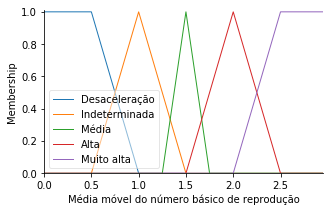

In [6]:
# Variável antecedente: média móvel do número de reprodução básico.
rt = ctrl.Antecedent(np.arange(0, 3, 0.05), 'Média móvel do número básico de reprodução')

rt['Desaceleração'] = fuzz.trapmf(rt.universe, [0, 0, 0.5, 1.0])
rt['Indeterminada'] = fuzz.trimf(rt.universe, [0.5, 1, 1.5])
rt['Média']  = fuzz.trimf(rt.universe, [1.25, 1.5, 1.75])
rt['Alta']  = fuzz.trimf(rt.universe, [1.5, 2.0, 2.5])
rt['Muito alta']  = fuzz.trapmf(rt.universe, [2.0, 2.5, 3, 3])

rt.view()

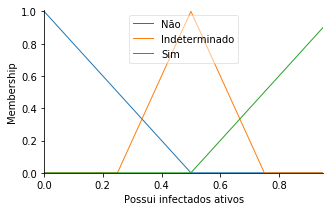

In [7]:
# Variável antecedente: possui infectados ativos.
ia = ctrl.Antecedent(np.arange(0, 1, 0.05), 'Possui infectados ativos')

ia['Não'] = fuzz.trimf(ia.universe, [0, 0, 0.5])
ia['Indeterminado'] = fuzz.trimf(ia.universe, [0.25, 0.5, 0.75])
ia['Sim']  = fuzz.trimf(ia.universe, [0.5, 1, 1])

ia.view()

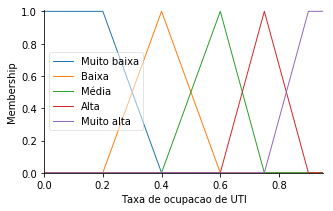

In [8]:
# Variável antecedente: taxa de ocupacao de UTI.
to_uti = ctrl.Antecedent(np.arange(0, 1, 0.05), 'Taxa de ocupacao de UTI')

to_uti['Muito baixa'] = fuzz.trapmf(to_uti.universe, [0, 0, 0.2, 0.4])
to_uti['Baixa'] = fuzz.trimf(to_uti.universe, [0.2, 0.4, 0.6])
to_uti['Média']  = fuzz.trimf(to_uti.universe, [0.4, 0.6, 0.75])
to_uti['Alta']  = fuzz.trimf(to_uti.universe, [0.6, 0.75, 0.9])
to_uti['Muito alta']  = fuzz.trapmf(to_uti.universe, [0.75, 0.9, 1, 1])

to_uti.view()

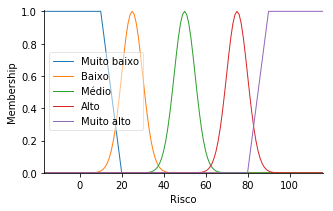

In [9]:
# Risco
risco = ctrl.Consequent(np.arange(-17, 117, 1), 'Risco')

risco['Muito baixo'] = fuzz.trapmf(risco.universe, [-17, -17, 10, 20])
risco['Baixo'] = fuzz.gaussmf(risco.universe, 25, 5)
risco['Médio'] = fuzz.gaussmf(risco.universe, 50, 5)
risco['Alto'] = fuzz.gaussmf(risco.universe, 75, 5)
risco['Muito alto']  = fuzz.trapmf(risco.universe, [80, 90, 117, 117])

risco.view()

In [10]:
#
# Regras
#

# Classificação epidemiológica
regra_ce_1 = ctrl.Rule(ce['Local'] & ~ia['Não'] 
                                   & ~(to_uti['Alta'] | to_uti['Muito alta']), risco['Baixo'])

# Infectados ativos.
regra_ia_1 = ctrl.Rule(ia['Não'] & ~ce['Local'] 
                                 & ~(to_uti['Alta'] | to_uti['Muito alta']), risco['Baixo'])

# Transmissão e infectados ativos
regra_ce_ia_1 = ctrl.Rule(ce['Indeterminada'] & ia['Indeterminado'], risco['Médio'])
regra_ce_ia_2 = ctrl.Rule(ce['Local'] & ia['Não'] 
                                      & ~(to_uti['Alta'] | to_uti['Muito alta']), risco['Muito baixo'])

# Velocidade de avanço
regra_vacn_1a = ctrl.Rule(vacn['Desaceleração'] & ~(to_uti['Alta'] | to_uti['Muito alta'])
                                                & ~ce['Comunitária'], risco['Muito baixo'])
regra_vacn_1b = ctrl.Rule(vacn['Desaceleração'] & ~(to_uti['Alta'] | to_uti['Muito alta'])
                                                &  ce['Comunitária'], risco['Alto'])
regra_vacn_1c = ctrl.Rule(vacn['Desaceleração'] & (to_uti['Alta'] | to_uti['Muito alta']), risco['Alto'])

regra_vacn_2a = ctrl.Rule(vacn['Indeterminada'] & ~(to_uti['Alta'] | to_uti['Muito alta'])
                                                & ~ce['Comunitária'], risco['Baixo'])
regra_vacn_2b = ctrl.Rule(vacn['Indeterminada'] &  (to_uti['Alta'] | to_uti['Muito alta']), risco['Alto'])
regra_vacn_3a = ctrl.Rule(vacn['Média'] & ~(to_uti['Alta'] | to_uti['Muito alta']), risco['Médio'])
regra_vacn_3b = ctrl.Rule(vacn['Média'] &  (to_uti['Alta'] | to_uti['Muito alta']), risco['Alto'])
regra_vacn_4a = ctrl.Rule(vacn['Alta'] & ~to_uti['Muito alta'], risco['Alto'])
regra_vacn_4b = ctrl.Rule(vacn['Alta'] &  to_uti['Muito alta'], risco['Muito alto'])
regra_vacn_5 = ctrl.Rule(vacn['Muito alta'], risco['Muito alto'])

# Rt
regra_rt_1a = ctrl.Rule(rt['Desaceleração'] & ~(to_uti['Alta'] | to_uti['Muito alta']) 
                                            & ~ce['Comunitária'], risco['Muito baixo'])
regra_rt_1b = ctrl.Rule(rt['Desaceleração'] & ~(to_uti['Alta'] | to_uti['Muito alta']) 
                                            &  ce['Comunitária'], risco['Médio'])
regra_rt_1c = ctrl.Rule(rt['Desaceleração'] & (to_uti['Alta'] | to_uti['Muito alta']), risco['Alto'])

regra_rt_2a = ctrl.Rule(rt['Indeterminada'] & ~(to_uti['Alta'] | to_uti['Muito alta']), risco['Baixo'])
regra_rt_2b = ctrl.Rule(rt['Indeterminada'] &  (to_uti['Alta'] | to_uti['Muito alta']), risco['Alto'])
regra_rt_3a = ctrl.Rule(rt['Média'] & ~(to_uti['Alta'] | to_uti['Muito alta']), risco['Médio'])
regra_rt_3b = ctrl.Rule(rt['Média'] &  (to_uti['Alta'] | to_uti['Muito alta']), risco['Alto'])
regra_rt_4a = ctrl.Rule(rt['Alta'] & ~to_uti['Muito alta'], risco['Alto'])
regra_rt_4b = ctrl.Rule(rt['Alta'] &  to_uti['Muito alta'], risco['Muito alto'])
regra_rt_5 = ctrl.Rule(rt['Muito alta'], risco['Muito alto'])

# Velocidade de avanço e Rt
regra_vacn_rt_1 = ctrl.Rule(vacn['Muito alta']  & rt['Muito alta'] , risco['Muito alto'])
regra_vacn_rt_2 = ctrl.Rule(vacn['Alta']  & rt['Alta'] , risco['Muito alto'])
regra_vacn_rt_3 = ctrl.Rule(vacn['Média']  & rt['Média'] , risco['Alto'])
regra_vacn_rt_4a = ctrl.Rule(vacn['Indeterminada']  & rt['Indeterminada'] 
                                                    & ~(to_uti['Alta'] | to_uti['Muito alta']) 
                                                    & ~ce['Comunitária'], risco['Médio'])
regra_vacn_rt_4b = ctrl.Rule(vacn['Indeterminada']  & rt['Indeterminada'] 
                                                    & (to_uti['Alta'] | to_uti['Muito alta']), risco['Alto'])
regra_vacn_rt_5a = ctrl.Rule(vacn['Desaceleração']  & rt['Desaceleração'] 
                                                    & ~(to_uti['Alta'] | to_uti['Muito alta']) 
                                                    & ~ce['Comunitária'], risco['Muito baixo'])
regra_vacn_rt_5b = ctrl.Rule(vacn['Desaceleração']  & rt['Desaceleração'] 
                                                    & (to_uti['Alta'] | to_uti['Muito alta']), risco['Alto'])
# Taxa de ocupação de UTI.
regra_to_uti_1 = ctrl.Rule(to_uti['Muito baixa'], risco['Muito baixo'])
regra_to_uti_2 = ctrl.Rule(to_uti['Baixa'], risco['Baixo'])
regra_to_uti_3 = ctrl.Rule(to_uti['Média'], risco['Médio'])
regra_to_uti_4 = ctrl.Rule(to_uti['Alta'], risco['Alto'])
regra_to_uti_5 = ctrl.Rule(to_uti['Muito alta'], risco['Muito alto'])

In [11]:
# Cria um sistema de controle e uma simulação
risco_covid_ctrl = ctrl.ControlSystem([regra_ce_1, #ce
                                       
                                       regra_ia_1, # ia
                                       
                                       regra_ce_ia_1, regra_ce_ia_2, # ia e ce
                                       
                                       regra_vacn_1a, regra_vacn_1b, regra_vacn_1c, regra_vacn_2a, # vacn e to_uti
                                       regra_vacn_2b, regra_vacn_3a, regra_vacn_3b, regra_vacn_4a, 
                                       regra_vacn_4b, regra_vacn_5,
                                       
                                       regra_rt_1a, regra_rt_1b, regra_rt_1c, regra_rt_2a, #rt e to_uti
                                       regra_rt_2b, regra_rt_3a, regra_rt_3b, regra_rt_4a, 
                                       regra_rt_4b, regra_rt_5,
                                       
                                       regra_vacn_rt_1, regra_vacn_rt_2, regra_vacn_rt_3, regra_vacn_rt_4a, # vacn e rt
                                       regra_vacn_rt_4b, regra_vacn_rt_5a, regra_vacn_rt_5b,
                                       
                                       regra_to_uti_1, regra_to_uti_2, regra_to_uti_3, # to_uti 
                                       regra_to_uti_4, regra_to_uti_5])

risco_covid_sim = ctrl.ControlSystemSimulation(risco_covid_ctrl)

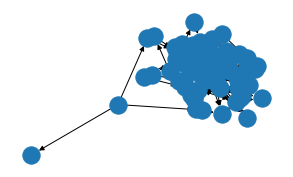

In [12]:
# Grafo das regras.
risco_covid_ctrl.view()

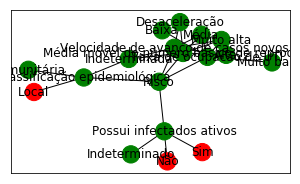

In [13]:
# Grafo das variáveis linguísticas.
risco_covid_ctrl.view_n()

In [14]:
def calculaRisco(aux):
    # Entrada.
    risco_covid_sim.input['Classificação epidemiológica'] = aux[1]
    risco_covid_sim.input['Possui infectados ativos'] = aux[2]
    risco_covid_sim.input['Média móvel do número básico de reprodução'] = aux[3]
    risco_covid_sim.input['Velocidade de avanço de casos novos'] = aux[4]
    risco_covid_sim.input['Taxa de ocupacao de UTI'] = aux[5] 

    # Cálculo.
    risco_covid_sim.compute()
    # print(risco_covid_sim.input)
    aux_risco = risco_covid_sim.output['Risco']
    if aux_risco < 0:
        aux_risco = 0
    elif aux_risco >100:
        aux_risco = 100    
    return(aux_risco)

In [15]:
calculaRisco(['Teste', 0, -1, 0, 0, 0])

6.158158515845791

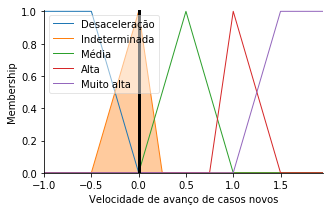

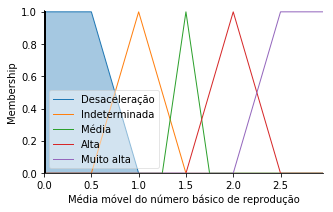

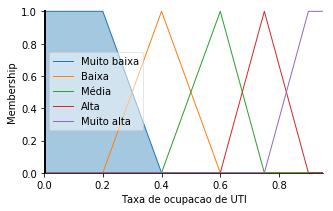

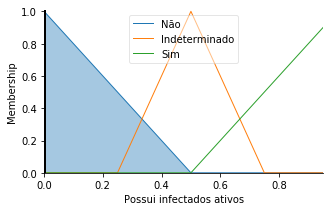

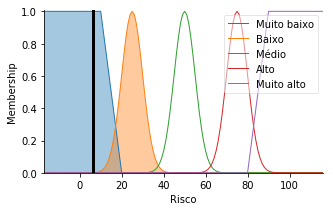

In [16]:
# Variáveis antecedentes.
vacn.view(sim=risco_covid_sim)
rt.view(sim=risco_covid_sim)
to_uti.view(sim=risco_covid_sim)
ia.view(sim=risco_covid_sim)

# Variável consequente.
risco.view(sim=risco_covid_sim)

In [17]:
df = pd.read_csv('2020-06-15 - bi_aglomerados.csv', decimal=',', sep=';')
df.head()

,municipio,cod_ibge,classificacao_epidemiologica,infectados_n,recuperados_n,obitos_n,r_025,r_500,r_975,r_mm7,n_va,p_va,ia_cat,iv_cat,risco,to_uti
0,Acorizal,5100102,TRANSMISSAO LOCAL,0,12,1,0.063560,0.440426,1.462090,1.363905,-0.152381,-0.152381,Muito baixo,Alto,Alto,0.759
1,Agua Boa,5100201,TRANSMISSAO LOCAL,3,6,1,0.344929,1.162162,2.774733,1.472414,0.928571,0.928571,Baixo,Alto,Alto,0.759
2,Alta Floresta,5100250,TRANSMISSAO COMUNITARIA,52,48,3,1.080522,1.404882,1.788479,2.161608,21.552381,21.552381,Moderado,Alto,Alto,0.759
3,Alto Araguaia,5100300,TRANSMISSAO LOCAL,3,8,2,0.648093,2.183608,5.213499,1.953173,-0.142857,-0.142857,Baixo,Alto,Alto,0.759
4,Alto Boa Vista,5100359,TRANSMISSAO LOCAL,6,12,1,0.018078,0.125267,0.415851,1.384019,NaN,NaN,Muito baixo,Alto,Alto,0.759


In [18]:
df = df[['municipio', 'classificacao_epidemiologica', 'infectados_n', 'r_mm7', 'p_va', 'to_uti']]
df.head()

,municipio,classificacao_epidemiologica,infectados_n,r_mm7,p_va,to_uti
0,Acorizal,TRANSMISSAO LOCAL,0,1.363905,-0.152381,0.759
1,Agua Boa,TRANSMISSAO LOCAL,3,1.472414,0.928571,0.759
2,Alta Floresta,TRANSMISSAO COMUNITARIA,52,2.161608,21.552381,0.759
3,Alto Araguaia,TRANSMISSAO LOCAL,3,1.953173,-0.142857,0.759
4,Alto Boa Vista,TRANSMISSAO LOCAL,6,1.384019,NaN,0.759


In [19]:
df.loc[~((df.classificacao_epidemiologica=='TRANSMISSAO COMUNITARIA') |
         (df.classificacao_epidemiologica=='TRANSMISSAO LOCAL'))
       , 'classificacao_epidemiologica'] = 0.5
df.loc[df.classificacao_epidemiologica=='TRANSMISSAO LOCAL', 'classificacao_epidemiologica'] = 0
df.loc[df.classificacao_epidemiologica=='TRANSMISSAO COMUNITARIA', 'classificacao_epidemiologica'] = 1


df.loc[np.isnan(df.infectados_n), 'infectados_n'] = 0.5
df.loc[df.infectados_n > 0, 'infectados_n'] = 1
df.loc[df.infectados_n == 0, 'infectados_n'] = 0

df.loc[np.isnan(df.r_mm7), 'r_mm7'] = 1
df.loc[np.isnan(df.p_va), 'p_va'] = 0

df.head()

,municipio,classificacao_epidemiologica,infectados_n,r_mm7,p_va,to_uti
0,Acorizal,0,0.0,1.363905,-0.152381,0.759
1,Agua Boa,0,1.0,1.472414,0.928571,0.759
2,Alta Floresta,1,1.0,2.161608,21.552381,0.759
3,Alto Araguaia,0,1.0,1.953173,-0.142857,0.759
4,Alto Boa Vista,0,1.0,1.384019,0.000000,0.759


In [20]:
df['risco'] = df.apply(calculaRisco, axis = 1)

In [21]:
df.to_csv('risco_fuzzy.csv', decimal=',', sep=';')

In [22]:
df.to_excel('risco_fuzzy.xlsx')

In [23]:
df

,municipio,classificacao_epidemiologica,infectados_n,r_mm7,p_va,to_uti,risco
0,Acorizal,0,0.0,1.363905,-0.152381,0.759,64.147155
1,Agua Boa,0,1.0,1.472414,0.928571,0.759,70.812579
2,Alta Floresta,1,1.0,2.161608,21.552381,0.759,93.363105
3,Alto Araguaia,0,1.0,1.953173,-0.142857,0.759,65.239016
4,Alto Boa Vista,0,1.0,1.384019,0.000000,0.759,70.812579
...,...,...,...,...,...,...,...
136,Vale de Sao Domingos,0.5,1.0,1.000000,0.000000,0.759,70.812579
137,Varzea Grande,1,1.0,1.132468,0.183171,0.759,70.812579
138,Vera,0.5,1.0,1.000000,0.000000,0.759,70.812579
139,Vila Bela da Santissima Trindade,0,1.0,0.726202,-0.084794,0.759,64.147155
